# Naive H&E classifier
Training set: patches from Y-pos vs Y-neg images.  
No attempt to distinguish background, stroma, tumor.  
Train vanilla CNN (but use VGG-compatible patch size).  
Expect no classification.

## Classify patches
Use a vanilla CNN.  
Repeat notebok 22 but change kernel size from 5 to 3.

In [1]:
import time
import os
#  os.environ['CUDA_VISIBLE_DEVICES'] = "0"   # turns off GPU?
import glob
import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
DIR_IMAGES_IN = "/home/jrm/Martinez/images/HEpatches/"  
PATCH_SIZE=224  # matches VGG
DIR_MODELS = "/home/jrm/Martinez/models/"
FILE_MODEL = "HE_Filter.023"    # May get overwritten
filepath=DIR_MODELS+FILE_MODEL
print("Will overwrite model at "+filepath)
BATCH_SIZE = 32
IMG_SIZE = (PATCH_SIZE,PATCH_SIZE)

Will overwrite model at /home/jrm/Martinez/models/HE_Filter.023


In [3]:
train_dir = os.path.join(DIR_IMAGES_IN, 'train')
valid_dir = os.path.join(DIR_IMAGES_IN, 'valid')
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_dataset = keras.utils.image_dataset_from_directory(
    valid_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 46216 files belonging to 2 classes.
Found 11553 files belonging to 2 classes.


In [4]:
# Normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1.0/255.0)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))

In [5]:
iterator = valid_dataset.take(10)
for x in iterator:
    print(x[0].shape)
    print(x[1])

(32, 224, 224, 3)
tf.Tensor([1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor([1 0

In [6]:
ACTIVATION="tanh"
NUM_CLASSES = 2
CHANNELS=3
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,CHANNELS]
cnn = keras.models.Sequential([
    #kl.RandomFlip(),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="SAME",input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(64,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(64,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(32,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(16,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(NUM_CLASSES,activation="softmax")
])


In [7]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=5
start = time.time()
hist = cnn.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS)
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/5
1445/1445 [==============================] - 155s 105ms/step - loss: 0.5471 - accuracy: 0.7751 - val_loss: 0.5341 - val_accuracy: 0.7786
Epoch 2/5
1445/1445 [==============================] - 152s 105ms/step - loss: 0.5265 - accuracy: 0.7785 - val_loss: 0.5119 - val_accuracy: 0.7786
Epoch 3/5
1445/1445 [==============================] - 152s 105ms/step - loss: 0.5095 - accuracy: 0.7780 - val_loss: 0.5245 - val_accuracy: 0.7787
Epoch 4/5
1445/1445 [==============================] - 152s 105ms/step - loss: 0.4937 - accuracy: 0.7796 - val_loss: 0.4726 - val_accuracy: 0.7918
Epoch 5/5
1445/1445 [==============================] - 152s 105ms/step - loss: 0.4847 - accuracy: 0.7826 - val_loss: 0.4739 - val_accuracy: 0.7943
Elapsed time: 761.9168281555176


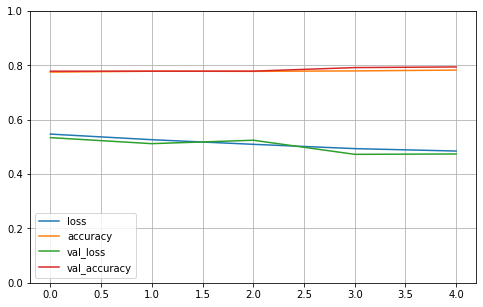

In [8]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()

In [9]:
cnn.save(filepath)

INFO:tensorflow:Assets written to: /home/jrm/Martinez/models/HE_Filter.023/assets


Note the portion of patches that are Ypos is  
35985 / (35985 + 10233) = 0.77859